In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml
# For the noise part later
from pennylane_cirq import ops as cirq_ops

# isn't there anything similar from tensorflow? split_dataset (tensorflow.keras.utils) only divides in left and right
# There is but the data-type outcome is shitty, its PrefetchData, and it's annoying to work with it, I am open if you get it to work properly
# Included the orders in the loading section, test it for yourself :)

from sklearn.model_selection import train_test_split

# Direct classes included for easyness
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential


In [ ]:
# Load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)
# seed = np.random.seed(156703)
# x_train, x_test = tf.keras.utils.split_dataset(input, right_size=test_split, shuffle = True, seed=seed)
# y_train, y_test = tf.keras.utils.split_dataset(noise_output, right_size=test_split, shuffle = True, seed=seed)

In [ ]:
from pennylane import numpy as np
# In a first try, we use as much qubits as we have input params

n_qubits = x_train.shape[1]

dev = qml.device("default.qubit", wires=n_qubits)  # number of shots default?

@qml.qnode(dev)
def qnode(inputs, weightshapes):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')
    qml.BasicEntanglerLayers(weightshapes, wires=range(n_qubits), rotation=qml.RX)
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [4]:
#Create a simple ANN
clear_session()
layer_0 = Input(shape=(x_train.shape[1],))
layer_1 = Dense(5, activation="relu")
layer_2 = Dense(5, activation="linear")
ann = Sequential([layer_0, layer_1, qlayer, layer_2])
ann.summary()

plot_model(ann)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 42        
                                                                 
 dense_1 (Dense)             (None, 15)                120       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [5]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']
ann.compile(optimizer = 'rmsprop', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
ann_history = ann.fit(x_train, y_train, epochs=250, batch_size=25, validation_split=0.25)

Epoch 1/250
31/31 [==============================] - 1s 15ms/step - loss: 15571.2812 - mean_squared_error: 15571.2812 - mean_absolute_error: 124.5895 - val_loss: 15410.3154 - val_mean_squared_error: 15410.3154 - val_mean_absolute_error: 123.9438
Epoch 2/250
31/31 [==============================] - 0s 5ms/step - loss: 15489.4336 - mean_squared_error: 15489.4336 - mean_absolute_error: 124.2593 - val_loss: 15325.8584 - val_mean_squared_error: 15325.8584 - val_mean_absolute_error: 123.6017
Epoch 3/250
31/31 [==============================] - 0s 5ms/step - loss: 15402.5195 - mean_squared_error: 15402.5195 - mean_absolute_error: 123.9080 - val_loss: 15231.7666 - val_mean_squared_error: 15231.7666 - val_mean_absolute_error: 123.2197
Epoch 4/250
31/31 [==============================] - 0s 4ms/step - loss: 15302.2637 - mean_squared_error: 15302.2637 - mean_absolute_error: 123.5012 - val_loss: 15118.3359 - val_mean_squared_error: 15118.3359 - val_mean_absolute_error: 122.7573
Epoch 5/250
31/31 [

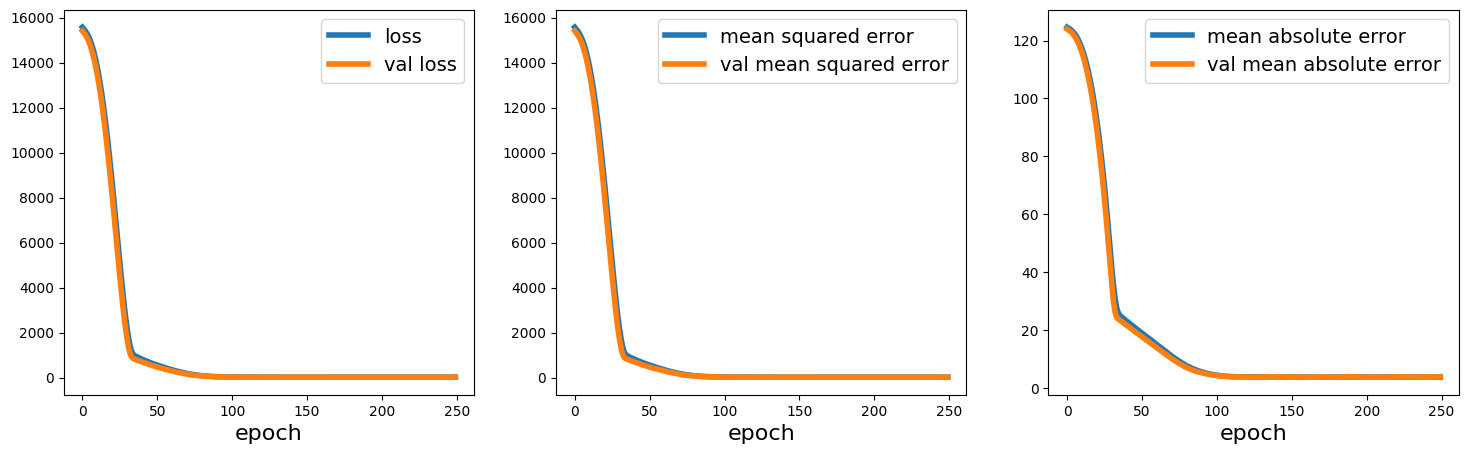

In [6]:
import numpy as np
def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(ann_history)

In [7]:
evaluation = ann.evaluate(x_test[:-1], y_test[:-1])

16/16 [==============================] - 0s 2ms/step - loss: 24.1454 - mean_squared_error: 24.1454 - mean_absolute_error: 3.8855
